In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We will use the AMES housing dataset by Dean De Cock

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', sep='\t') # Tab separated
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [3]:
# This is unnecessarily large, so let's pick out a subset of 5 variables, along wit the target
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']

df = df[columns]
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Overall Qual   2930 non-null   int64  
 1   Overall Cond   2930 non-null   int64  
 2   Gr Liv Area    2930 non-null   int64  
 3   Central Air    2930 non-null   object 
 4   Total Bsmt SF  2929 non-null   float64
 5   SalePrice      2930 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 137.5+ KB
None
   Overall Qual  Overall Cond  Gr Liv Area Central Air  Total Bsmt SF  \
0             6             5         1656           Y         1080.0   
1             5             6          896           Y          882.0   
2             6             6         1329           Y         1329.0   
3             7             5         2110           Y         2110.0   
4             5             5         1629           Y          928.0   

   SalePrice  
0     215000  
1   

In [4]:
# There is only one missing entry. Let's drop that row, since we have a large enough dataset
df = df.dropna(axis=0)
# Let's encode the central air conditioning variable
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})
print(df.shape)

(2929, 6)


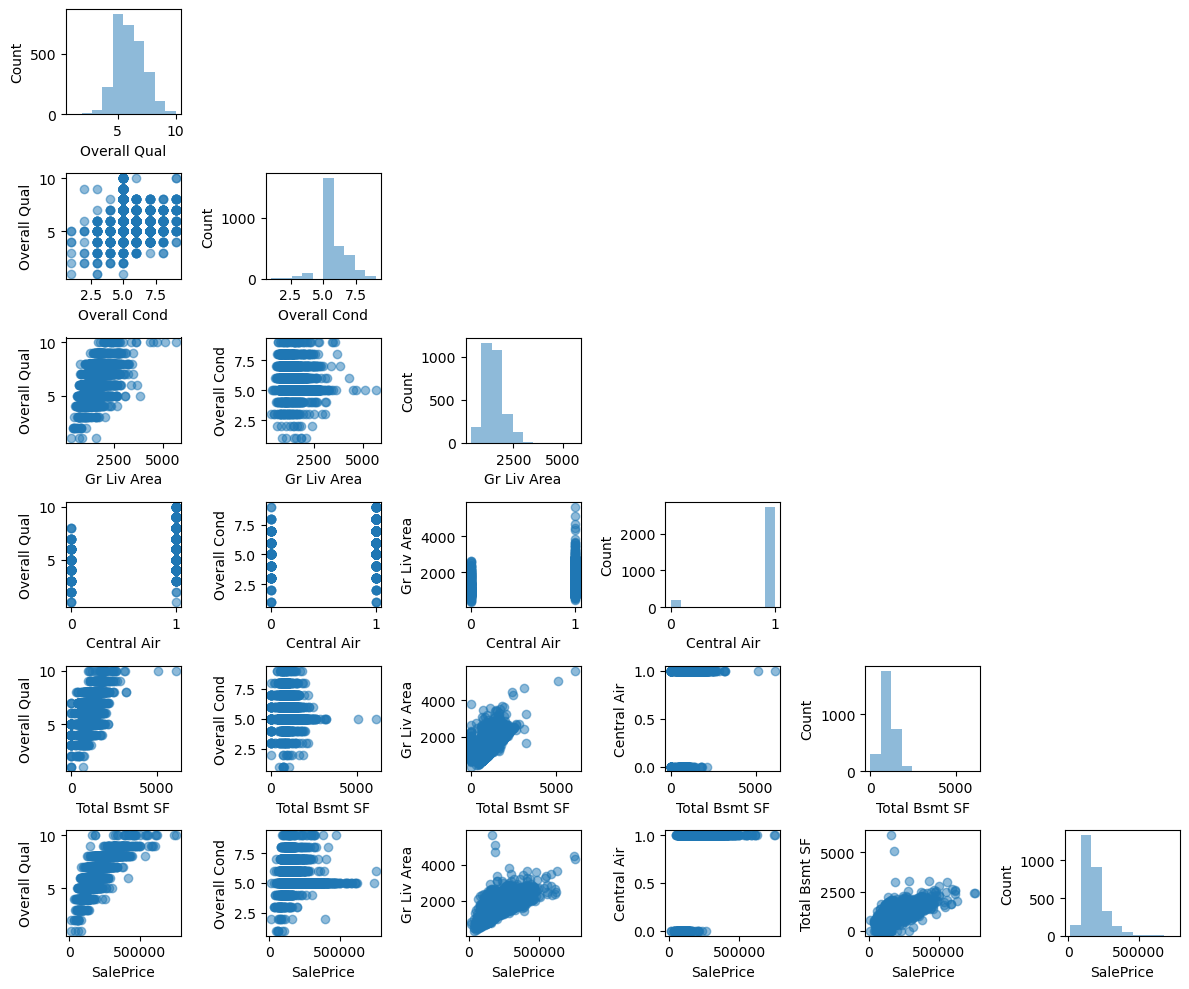

In [5]:
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show() 

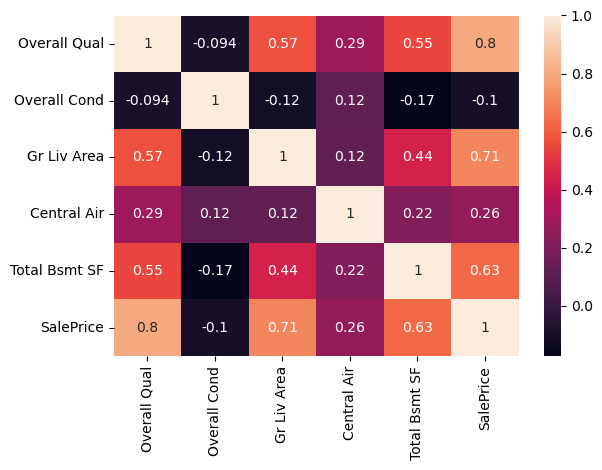

In [6]:
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from lin_reg import LinearRegressionGD

# Let's start with a 1D example, with the Gr Liv Area

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

sc_x = StandardScaler()
sc_y = StandardScaler()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = sc_x.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten() # the fit transform expects a 2D array

X_test = sc_x.transform(X_test)
y_test = sc_y.transform(y_test.reshape(-1, 1)).flatten()

lr = LinearRegressionGD(learning_rate=0.1)

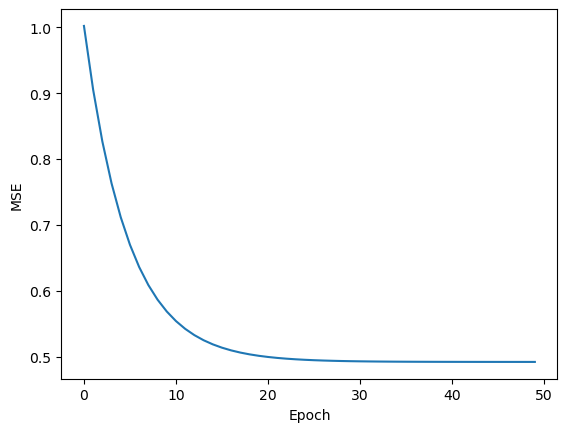

In [8]:
lr.fit(X_train, y_train)
plt.plot(lr.losses_)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [9]:
import os

original_dir = os.getcwd()
os.chdir('..')

from regression_plotting import RegressionFitPlotter
os.chdir(original_dir)

rfp = RegressionFitPlotter()

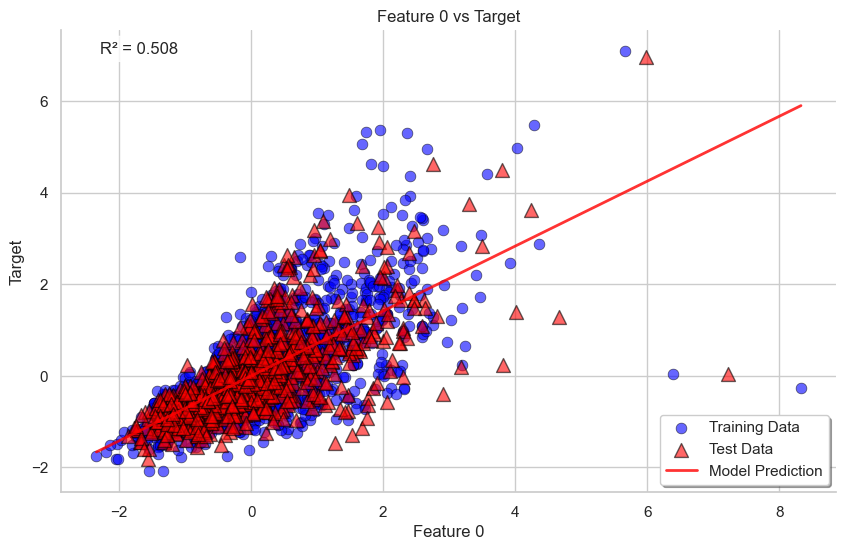

In [10]:
rfp.plot_feature_vs_target(X_train, y_train, feature_index=0, 
                      regressor=lr, X_test=X_test, y_test=y_test)
plt.show()

In [11]:
# Not a perfect estimator
intercept = sc_y.inverse_transform(np.array([lr.w_[0]])[:, np.newaxis]).flatten()
slope = lr.w_[1]
print(f"For standardized variables, the model suggests that y = {lr.w_[1]:.3f} * x + {lr.w_[0]:.3f}. Due to the linear regression formula for the intercept, we expect the intercept to be 0 for a standardized variable.")
# To reinterpret in terms of unstandardized variables, inverse transform the intercept back with sc_y, and the slope needs to be rescaled by the std(Y_train)/std(X_train)

For standardized variables, the model suggests that y = 0.709 * x + 0.000. Due to the linear regression formula for the intercept, we expect the intercept to be 0 for a standardized variable.


In [12]:
# Now we do the same with sklearn
from sklearn.linear_model import LinearRegression
# Scipy and sklearn actually work better with unstandardized variables since they use the normal equations

slr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

slr.fit(X_train, y_train)

print(f"Model suggests: y = {slr.coef_[0]:.3f} * x + {slr.intercept_:.3f}")

Model suggests: y = 107.362 * x + 18895.444


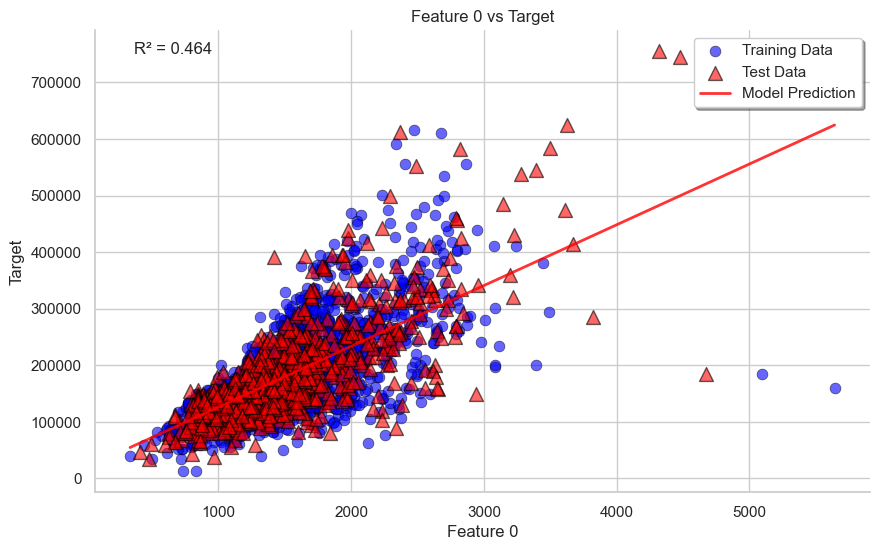

In [13]:
rfp.plot_feature_vs_target(X_train, y_train, feature_index=0, 
                      regressor=slr, X_test=X_test, y_test=y_test)
plt.show()

In [18]:
# Using the normal equations!

x_var = np.stack((np.ones_like(X_train.flatten(), dtype=float), X_train.flatten())).T
beta_est = np.linalg.inv(x_var.T @ x_var) @ x_var.T @ y_train
SS_tot = np.linalg.norm((y_train - np.mean(y_train)))**2
SS_res = np.linalg.norm((y_train - x_var @ beta_est))**2

print(f"R squared = {1 - (SS_res/SS_tot)}")

R squared = 0.4637172782565768
